In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
from nltk.corpus import stopwords
import nltk
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load dataset
file_path = "/Users/akash/Downloads/amazon_reviews.csv"
df = pd.read_csv(file_path)

# Selecting relevant columns and drop missing values
df = df[['content', 'score', 'at']].dropna()

# Converting timestamp column to datetime format (for time-based analysis)
df['at'] = pd.to_datetime(df['at'])

# Defining sentiment labels based on scores (1-2: Negative, 3: Neutral, 4-5: Positive)
def assign_sentiment(score):
    if score <= 2:
        return "Negative"
    elif score == 3:
        return "Neutral"
    else:
        return "Positive"

df['sentiment'] = df['score'].apply(assign_sentiment)

# EDA (Exploratory Data Analysis)

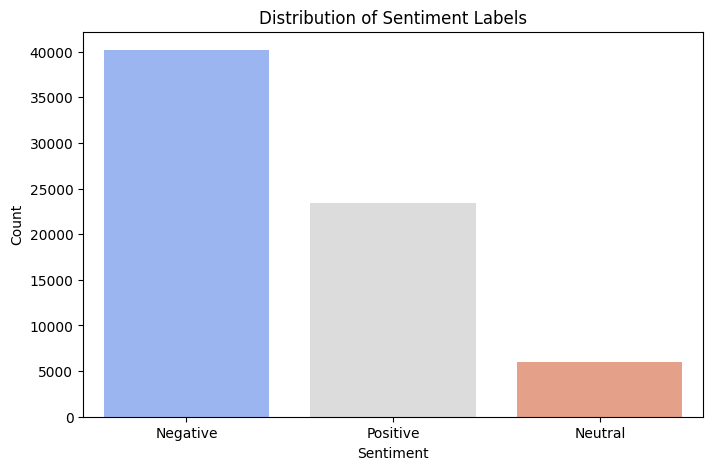

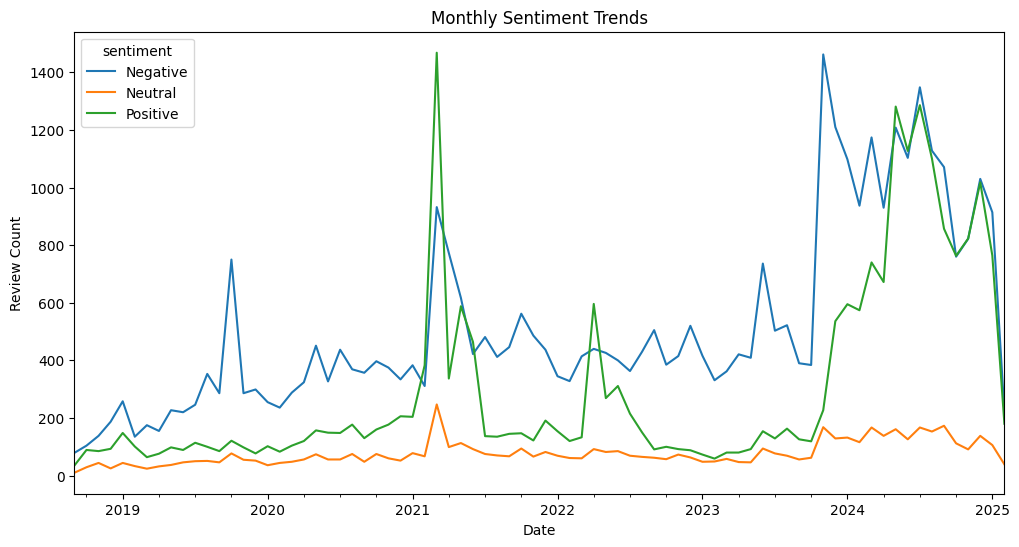

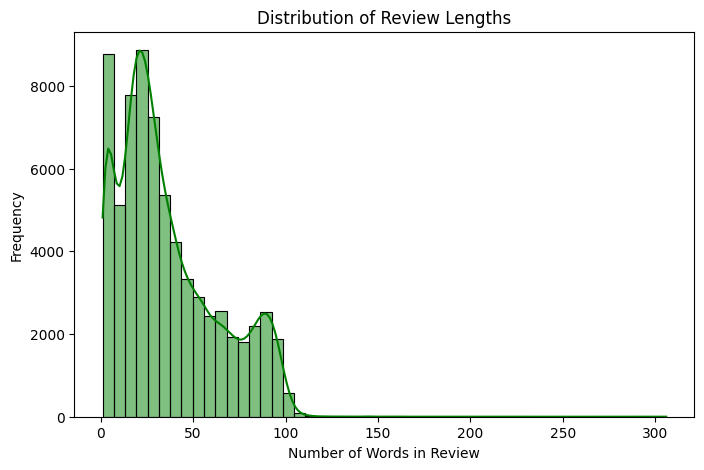

In [5]:
# Distribution of Sentiment Labels
plt.figure(figsize=(8,5))
sns.countplot(x=df['sentiment'], palette="coolwarm")
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Time-Based Sentiment Analysis
df.set_index('at').resample('M')['sentiment'].value_counts().unstack().plot(figsize=(12,6))
plt.title("Monthly Sentiment Trends")
plt.xlabel("Date")
plt.ylabel("Review Count")
plt.show()

# Review Length Analysis
df["review_length"] = df["content"].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8,5))
sns.histplot(df["review_length"], bins=50, kde=True, color="green")
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words in Review")
plt.ylabel("Frequency")
plt.show()

# Data Pre processing and Natural Language Processing (NLP)

In [7]:
nltk.download('stopwords')

nltk_stopwords = set(stopwords.words('english'))

predefined_stopwords = {"amazon", "app", "customer", "product", "buy", "shopping", 
                        "website", "online", "feature", "s"}
combined_stopwords = nltk_stopwords.union(predefined_stopwords)

def clean_text(text, stopwords):
    text = str(text).lower()
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = ' '.join([word for word in text.split() if word not in stopwords])  # Remove stopwords
    return text

df['cleaned_content'] = df['content'].apply(lambda x: clean_text(x, combined_stopwords))

def get_most_common_words(df, sentiment, num_words=20):
    words = ' '.join(df[df['sentiment'] == sentiment]['cleaned_content']).split()
    common_words = Counter(words).most_common(num_words)
    return dict(common_words)

positive_words = get_most_common_words(df, "Positive")
negative_words = get_most_common_words(df, "Negative")

[nltk_data] Downloading package stopwords to /Users/akash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


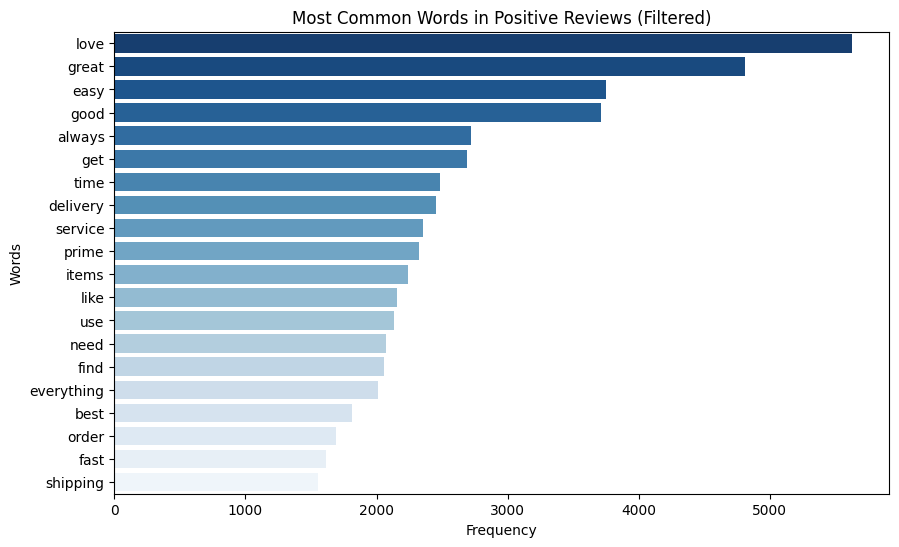

In [9]:
# Plot most common words for positive reviews
plt.figure(figsize=(10, 6))
sns.barplot(x=list(positive_words.values()), y=list(positive_words.keys()), palette="Blues_r")
plt.title("Most Common Words in Positive Reviews (Filtered)")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

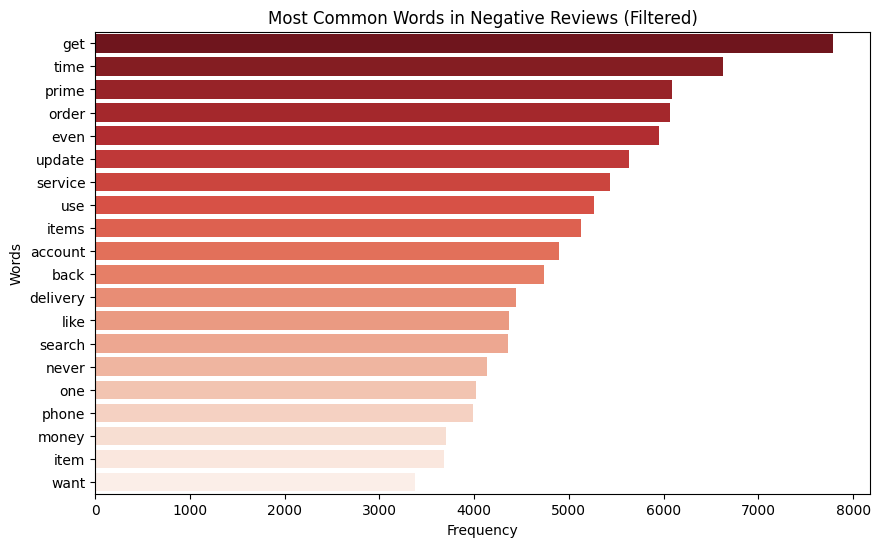

In [11]:
# Plot most common words for negative reviews
plt.figure(figsize=(10, 6))
sns.barplot(x=list(negative_words.values()), y=list(negative_words.keys()), palette="Reds_r")
plt.title("Most Common Words in Negative Reviews (Filtered)")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

## WordCloud

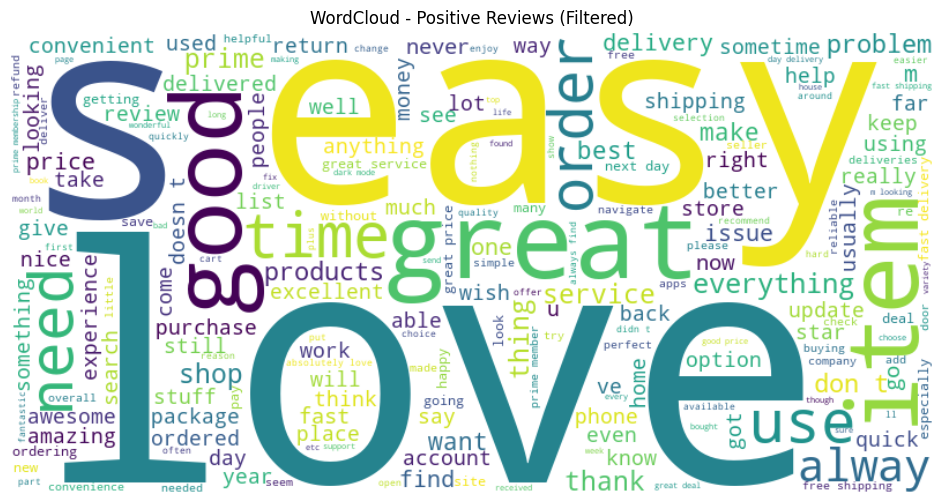

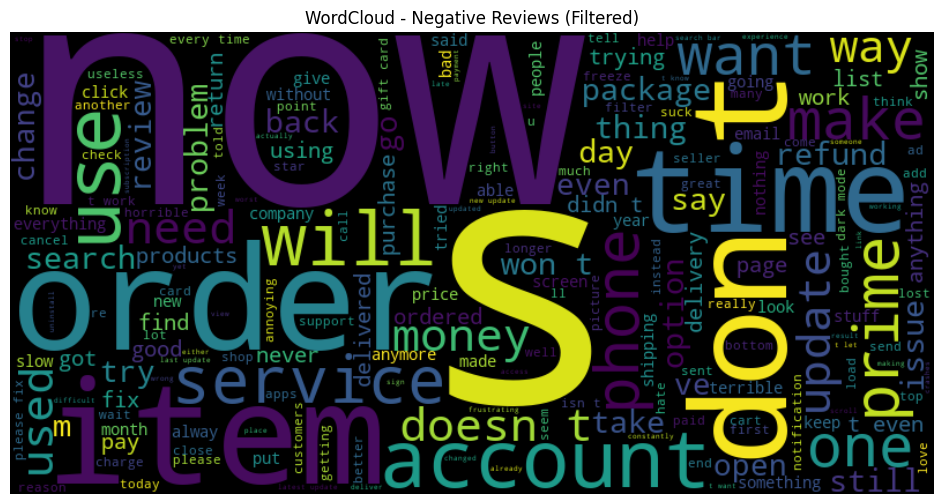

In [12]:
custom_stopwords = set(["amazon", "app", "customer", "product", "buy", "shopping", 
                        "website", "online", "feature","S" ])

def clean_text(text):
    text = text.lower()  
    text = re.sub(r'\W', ' ', text)  
    text = re.sub(r'\s+', ' ', text)  
    text = ' '.join([word for word in text.split() if word not in custom_stopwords])  
    return text

df["cleaned_content"] = df["content"].apply(clean_text)

positive_text = ' '.join(df[df['sentiment'] == "Positive"]['cleaned_content'])
wordcloud_positive = WordCloud(width=800, height=400, background_color="white").generate(positive_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Positive Reviews (Filtered)")
plt.show()

negative_text = ' '.join(df[df['sentiment'] == "Negative"]['cleaned_content'])
wordcloud_negative = WordCloud(width=800, height=400, background_color="black").generate(negative_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Negative Reviews (Filtered)")
plt.show()

## Topic Modeling

In [14]:
vectorizer_lda = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf_lda = vectorizer_lda.fit_transform(df['content'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_tfidf_lda)

terms = vectorizer_lda.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    print(f"Topic {i}: ", [terms[i] for i in topic.argsort()[-10:]])

Topic 0:  ['crashing', 'slow', 'load', 'just', 'phone', 'open', 'fix', 'keeps', 'update', 'app']
Topic 1:  ['don', 'reviews', 'products', 'delivery', 'company', 'app', 'bad', 'service', 'amazon', 'customer']
Topic 2:  ['use', 'way', 'option', 'want', 'amazon', 'like', 'mode', 'dark', 'app', 'search']
Topic 3:  ['card', 'shipping', 'time', 'delivery', 'day', 'money', 'account', 'order', 'prime', 'amazon']
Topic 4:  ['delivery', 'app', 'fast', 'best', 'shopping', 'easy', 'amazon', 'great', 'good', 'love']


# Sentiment Analysis (Machine Learning)

In [17]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['sentiment'], test_size=0.2, random_state=42)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=200)
model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = model.predict(X_test_tfidf)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Displaying Model Performance
print(f"Model Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Model Accuracy: 0.84
Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      0.95      0.89      8012
     Neutral       0.36      0.05      0.09      1244
    Positive       0.87      0.86      0.87      4676

    accuracy                           0.84     13932
   macro avg       0.69      0.62      0.62     13932
weighted avg       0.80      0.84      0.81     13932



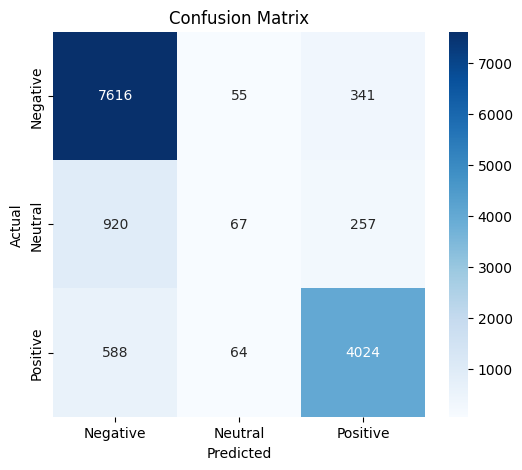

In [18]:
# Confusion Matrix Visualization
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance (Most Influential words)

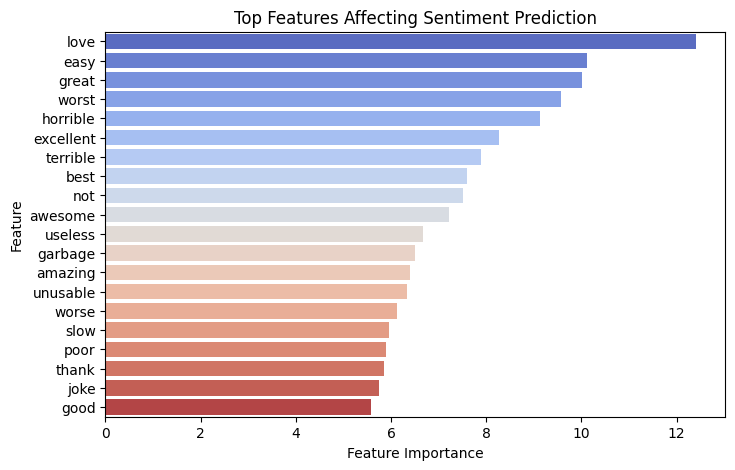

In [20]:
feature_importance = pd.DataFrame({"Feature": vectorizer.get_feature_names_out(), "Importance": np.abs(model.coef_).sum(axis=0)})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False).head(20)

plt.figure(figsize=(8,5))
sns.barplot(x=feature_importance["Importance"], y=feature_importance["Feature"], palette="coolwarm")
plt.title("Top Features Affecting Sentiment Prediction")
plt.xlabel("Feature Importance")
plt.show()